## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
###pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

In [2]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  ###print("Model doesn't exist, downloading...")
  ###os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [3]:
import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library

#設定XML檔(label)和圖片檔(image)的資料夾路徑
labelpath = 'C:/Users/4D212/Documents/GitHub/49_50final/keras-yolo3-master/labels' 
imagepath = 'C:/Users/4D212/Documents/GitHub/49_50final/keras-yolo3-master/images' 

#取得所有XML檔的檔名
labelnames = os.listdir(labelpath)

#在當前資料夾建立一個 train.txt檔 用來存圖片的框選資訊
Tfile = open('train.txt','w')

#遍歷每個XML檔 統合所有資訊
#目標 做出以下格式的train.txt檔: image_file_path box1 box2 ... boxN
#其中box格式為: x_min,y_min,x_max,y_max,class_id 
for labelfile in labelnames:
    #接出XML檔案路徑 和 圖檔路徑
    XMLpath = labelpath + '/' + labelfile
    PICpath = imagepath + '/' + labelfile[0:-3] + 'jpg' ###這裡我把附檔名'xml'去掉 改成圖檔的副檔名'jpg'
    
    #寫入每一列的第一筆資訊 --- image_file_path
    Tfile.write(PICpath)
    
    #開啟XML檔 讀取資訊
    with open(XMLpath) as in_file:
        tree = ET.parse(in_file)
        root = tree.getroot()
        
        #找出每個object結構 一個object代表一筆標記框訊息
        for obj in root.iter('object'):
            #bndbox結構是存位置資訊的地方
            bbx = obj.find('bndbox')
            #寫入標記框的資訊
            Tfile.write(' ' + bbx.find('xmin').text + 
                        ',' + bbx.find('ymin').text + 
                        ',' + bbx.find('xmax').text + 
                        ',' + bbx.find('xmax').text
                       )
            #我把袋鼠class_id設為0 浣熊class_id為1
            if(obj.find('name').text == 'kangaroo'):
                Tfile.write(',0')
            else:
                Tfile.write(',1')
    #一個XML檔的所有資料在train.txt中寫成一列 故每個XML檔讀完後要換行
    Tfile.write('\n')
#全都寫完後關閉train.txt           
Tfile.close()

以下的程式碼負責把下載下來的 Pascal VOC 資料集轉換為訓練模型時需要的格式，直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，調整了一部分程式碼，讓我們只 sample 前 100 張圖片來做示範，在 colab 中會花一些時間跑完

In [4]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

C:\Users\4D212\Anaconda3\envs\dlm\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\4D212\Anaconda3\envs\dlm\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\4D212\Anaconda3\envs\dlm\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\4D212\Anaconda3\envs\dlm\lib\site-p

In [5]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [6]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES =True

annotation_path = 'final_train.txt' # 轉換好格式的標註檔案 --> 剛剛的train.txt 我改名成final_train.txt
log_dir = 'logs/001/' # 訓練好的模型儲存的路徑 從000改成001 換個名字 不跟作業41的重複
classes_path = 'model_data/final_classes.txt' #自己照voc_classes.txt寫一個final_classes.txt 裡面放訓練的種類名稱 照class_id的順續放
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


C:\Users\4D212\Anaconda3\envs\dlm\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\4D212\Anaconda3\envs\dlm\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\4D212\Anaconda3\envs\dlm\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\4D212\Anaconda3\envs\dlm\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\4D212\Anaconda3\envs\dlm\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loa

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 328 samples, val on 36 samples, with batch size 16.
Epoch 1/50
20/20 [==============================] - 436s 22s/step - loss: 3450.6195 - val_loss: 915.0908
Epoch 2/50
20/20 [==============================] - 436s 22s/step - loss: 541.7748 - val_loss: 303.4024
Epoch 3/50
20/20 [==============================] - 435s 22s/step - loss: 238.1202 - val_loss: 184.6156
Epoch 4/50
20/20 [==============================] - 433s 22s/step - loss: 165.8457 - val_loss: 134.6969
Epoch 5/50
20/20 [==============================] - 433s 22s/step - loss: 133.7729 - val_loss: 113.9740
Epoch 6/50
20/20 [==============================] - 431s 22s/step - loss: 109.0760 - val_loss: 96.8760
Epoch 7/50
20/20 [==============================] - 424s 21s/step - loss: 95.6970 - val_loss: 81.1430
Epoch 8/50
20/20 [==============================] - 424s 21s/step - loss: 83.6490 - val_loss: 70.5266
Epoch 9/50
20/20 [===

20/20 [==============================] - 1229s 61s/step - loss: 14.5598 - val_loss: 16.6185
Epoch 00074: early stopping


In [12]:
from PIL import Image
image = Image.open('raccoon_test.jpg') 

In [13]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/001/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 3 boxes for img
raccoon 0.79 (641, 176) (1382, 1026)
raccoon 0.92 (1208, 88) (2000, 867)
raccoon 0.94 (5, 37) (827, 880)
3.443329662337419


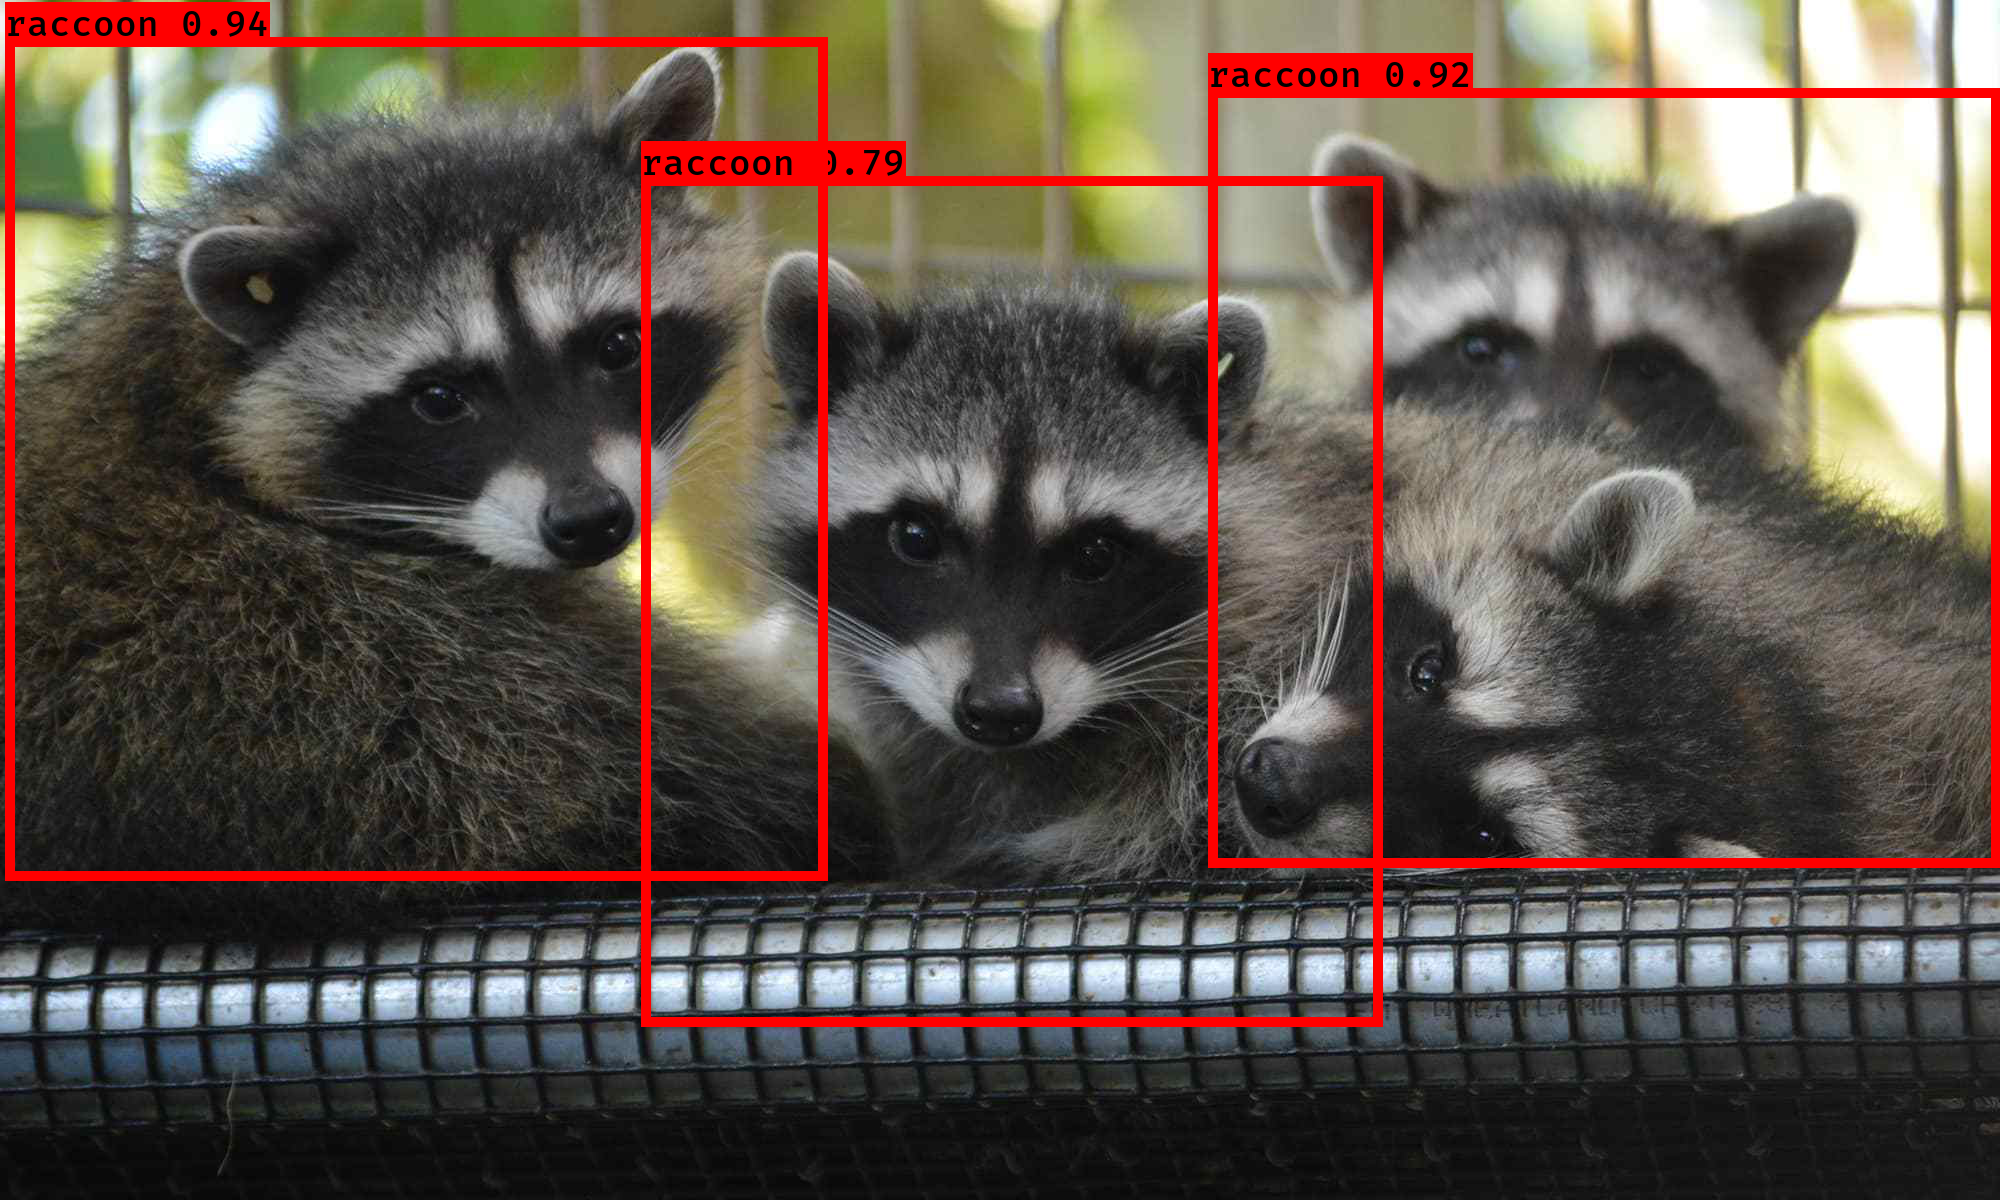

In [14]:
r_image

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (518, 244) (684, 600)
kangaroo 0.72 (0, 161) (165, 600)
kangaroo 0.84 (240, 108) (450, 600)
1.403752450216416


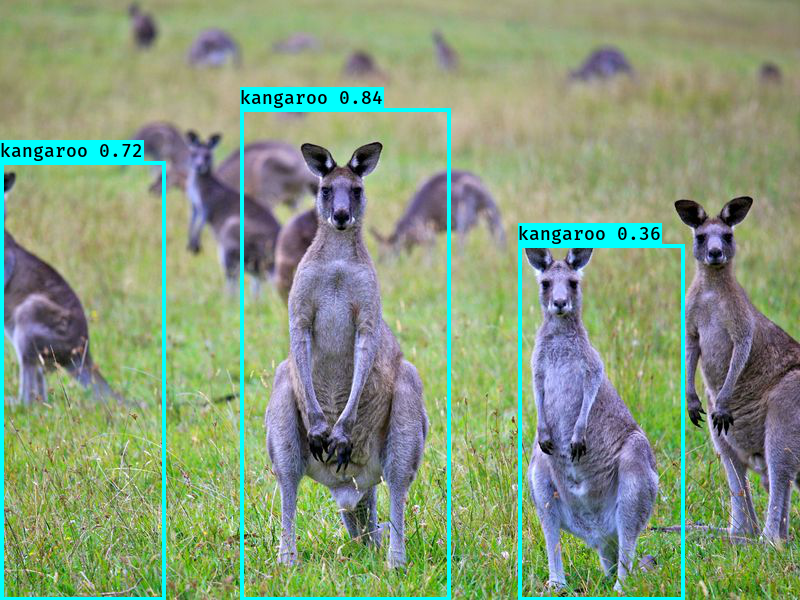

In [15]:
image = Image.open('kangaroo_test.jpg')
r_image = yolo_model.detect_image(image)
r_image